# **Character-Level LSTM Language Model**

## **From Scratch Implementation in NumPy**

This notebook implements a **vanilla LSTM** for character-level language modeling.


### **What We'll Build:**
- **Vanilla LSTM** with three (forget, input, output) gates
- **Backpropagation** for gradient computation
- **Character-level text generation** from learned patterns
---
*Notebook by*: Ahmad Raza [@ahmadrazacdx](https://github.com/ahmadrazacdx)<br>
*Date: 2025*  
*License: MIT*

In [1]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8')

In [2]:
#Load Data
data = open('../data/thirsty_crow.txt', 'r').read()
chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print(f'Data has {data_size} characters, {vocab_size} unique.')

Data has 677 characters, 33 unique.


In [3]:
char_to_ix = {ch:i for i,ch in enumerate(chars)}

In [4]:
ix_to_char = {i:ch for i,ch in enumerate(chars)}

### __HYPER-PARAMETERS__

In [5]:
lr = 1e-3 # learning rate
seq_len = 25 # times LSTM will be unrolled (Timesteps)
hidden_size= 100 # size of hidden units

### __MODEL PARAM INIT__
**Initializing weight matrices for the LSTM.**

**Gate Weight Matrices (concatenated input $[\mathbf{h}_{t-1}; \mathbf{x}_t]$):**
- $\mathbf{W}_f \in \mathbb{R}^{H \times (H+V)}$ Forget gate weights
- $\mathbf{W}_i \in \mathbb{R}^{H \times (H+V)}$ Input gate weights
- $\mathbf{W}_c \in \mathbb{R}^{H \times (H+V)}$ Candidate cell state weights
- $\mathbf{W}_o \in \mathbb{R}^{H \times (H+V)}$ Output gate weights

**Output Layer:**
- $\mathbf{W}_y \in \mathbb{R}^{V \times H}$ Hidden-to-output weights


**Biases:**
- Gate biases: $\mathbf{b}_f, \mathbf{b}_i, \mathbf{b}_c, \mathbf{b}_o \in \mathbb{R}^{H \times 1}$
- Output bias:  $\mathbf{b}_y \in \mathbb{R}^{V \times 1}$

**Total parameters:** $4H(H+V) + VH + 4H + V$ <br>
= **4×100×133 + 33×100 + 5×100 + 33 = $56,933$ parameters**

**Where:**   $V$ = vocabulary size (33 unique chars), $H$ = hidden size (100)

**Note:** A small but important implementation detail is that initializing the LSTM’s forget-gate bias to **1** helps prevent early forgetting and improves gradient flow. This recommendation was empirically emphasized by *Jozefowicz et al. (2015)*.


In [6]:
Wf = np.random.randn(hidden_size, hidden_size+vocab_size)*0.01 # Forget Gate weights (H, H+V)
Wi = np.random.randn(hidden_size, hidden_size+vocab_size)*0.01 # Input Gate weights (H, H+V)
Wc = np.random.randn(hidden_size, hidden_size+vocab_size)*0.01 # Candidate Cell State  weights (H, H+V)
Wo = np.random.randn(hidden_size, hidden_size+vocab_size)*0.01 # Output Gate weights (H, H+V)
Wy = np.random.randn(vocab_size, hidden_size)*0.01 # Prediction weights (V, H)
bf = np.ones((hidden_size, 1)) # Forget Gate bias (H, 1) -Jozefowicz et al (2015).
bi = np.zeros((hidden_size, 1)) # Input Gate bias(H, 1)
bo = np.zeros((hidden_size, 1)) # Output Gate bias (H, 1)
bc = np.zeros((hidden_size, 1)) # CCS bias (H, 1)
by = np.zeros((vocab_size, 1)) # prediction bias (V, 1)

In [7]:
print(f"""
Wf: Forget Gate Weights  : {Wf.shape}
Wi: Input Gate Weights   : {Wi.shape}
Wc: CCS Weights          : {Wc.shape}
Wo: Output Gate Weights  : {Wo.shape}
Wy: Prediction Weights   : {Wy.shape}
bf: Forget Gate bias     : {bf.shape}
bi: Input Gate bias      : {bi.shape}
bc: CCS bias             : {bc.shape}
bo: Output Gate bias     : {bo.shape}
by: Prediction bias      : {by.shape}
""")


Wf: Forget Gate Weights  : (100, 133)
Wi: Input Gate Weights   : (100, 133)
Wc: CCS Weights          : (100, 133)
Wo: Output Gate Weights  : (100, 133)
Wy: Prediction Weights   : (33, 100)
bf: Forget Gate bias     : (100, 1)
bi: Input Gate bias      : (100, 1)
bc: CCS bias             : (100, 1)
bo: Output Gate bias     : (100, 1)
by: Prediction bias      : (33, 1)



### __ADAM OPTIMIZER INITIALIZATION__

In [8]:
# Adam hyperparameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Adam memory variables (first moment)
mWf = np.zeros_like(Wf)
mWi = np.zeros_like(Wi)
mWc = np.zeros_like(Wc)
mWo = np.zeros_like(Wo)
mWy = np.zeros_like(Wy)
mbf = np.zeros_like(bf)
mbi = np.zeros_like(bi)
mbc = np.zeros_like(bc)
mbo = np.zeros_like(bo)
mby = np.zeros_like(by)

# Adam memory variables (second moment)
vWf = np.zeros_like(Wf)
vWi = np.zeros_like(Wi)
vWc = np.zeros_like(Wc)
vWo = np.zeros_like(Wo)
vWy = np.zeros_like(Wy)
vbf = np.zeros_like(bf)
vbi = np.zeros_like(bi)
vbc = np.zeros_like(bc)
vbo = np.zeros_like(bo)
vby = np.zeros_like(by)
# Timestep counter for bias correction
t_adam = 0

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

### __SINGLE LSTM CELL__

**LSTM Forward Pass Equations:**

$$
\begin{align}
\mathbf{z}_t &= [\mathbf{h}_{t-1}; \mathbf{x}_t] \quad &\text{(concatenated input)} \\
\mathbf{f}_t &= \sigma(\mathbf{W}_f \mathbf{z}_t + \mathbf{b}_f) \quad &\text{(forget gate)} \\
\mathbf{i}_t &= \sigma(\mathbf{W}_i \mathbf{z}_t + \mathbf{b}_i) \quad &\text{(input gate)} \\
\tilde{\mathbf{c}}_t &= \tanh(\mathbf{W}_c \mathbf{z}_t + \mathbf{b}_c) \quad &\text{(candidate cell state)} \\
\mathbf{c}_t &= \mathbf{f}_t \odot \mathbf{c}_{t-1} + \mathbf{i}_t \odot \tilde{\mathbf{c}}_t \quad &\text{(cell state update)} \\
\mathbf{o}_t &= \sigma(\mathbf{W}_o \mathbf{z}_t + \mathbf{b}_o) \quad &\text{(output gate)} \\
\mathbf{h}_t &= \mathbf{o}_t \odot \tanh(\mathbf{c}_t) \quad &\text{(hidden state)} \\
\mathbf{y}_t &=\mathbf{W}_y \mathbf{h}_t + \mathbf{b}_y \quad &\text{(output logits)}
\end{align}
$$

**Where:** $\sigma$ = sigmoid, $\odot$ = element-wise multiplication

**Reference:** Hochreiter & Schmidhuber (1997) - *Long Short-Term Memory*

In [10]:
def lstm(c_prev, h_prev, xt):
    """
    Single LSTM cell

    Inputs:
        - c_prev: Previous cell state (H, 1)
        - h_prev: Previous hidden state (H, 1)
        - xt: input charater (V, 1)

    Returns:
        - ft, it, cct, ot: Gate activations
        - ct: Current cell state (H, 1)
        - ht: Current hidden state (H, 1)
        - yt: Output logits (V, 1)
    """
    zt = np.concatenate((h_prev, xt), axis=0) # (H,1):(V,1)= (H+V,1)
    # Forget Gate
    zf = np.dot(Wf, zt) + bf #(H,H+V)@(H+V,1)->(H,1)+(H,1)=(H,1)
    ft = sigmoid(zf) # (H,1)
    #Input Gate
    zi = np.dot(Wi, zt) + bi #(H,H+V)@(H+V,1)->(H,1)+(H,1)=(H,1)
    it = sigmoid(zi) # (H,1)
    #Candidate Cell State
    zc = np.dot(Wc, zt) + bc #(H,H+V)@(H+V,1)->(H,1)+(H,1)=(H,1)
    cct = np.tanh(zc) # (H,1)
    #Cell State
    ct = ft * c_prev + it * cct # (H,1)*(H,1)+(H,1)*(H,1)=(H,1)
    #Output Gate
    zo = np.dot(Wo, zt) + bo #(H,H+V)@(H+V,1)->(H,1)+(H,1)=(H,1)
    ot = sigmoid(zo) # (H,1)
    #Hidden State
    ht = ot * np.tanh(ct) # (H,1)*(H,1)=(H,1)
    #Output Logits
    yt = np.dot(Wy, ht) + by # #(V,H)@(H,1)->(V,1)+(V,1)=(V,1)
    return ft, it, cct, ot, ct, ht, yt

**Understanding the LSTM Cell:**

**What's happening here?**
- At each timestep $t$, the LSTM takes three inputs:
  1. Current character $\mathbf{x}_t$ (one-hot vector)
  2. Previous hidden state $\mathbf{h}_{t-1}$
  3. Previous cell state $\mathbf{c}_{t-1}$ (long-term memory)
  
- It outputs:
  1. New hidden state $\mathbf{h}_t$ (short-term working memory)
  2. New cell state $\mathbf{c}_t$ (long-term memory)
  3. Output logits $\mathbf{y}_t$
  
**Key Advantage over Vanilla RNN:** The cell state $\mathbf{c}_t$ provides a "highway" for gradients to flow backward without vanishing, enabling learning of long-range dependencies (100+ timesteps)!

**The LSTM Magic - Three Gates:**

1. **Forget gate** ($\mathbf{f}_t$): Decides what to forget from $\mathbf{c}_{t-1}$.
2. **Output gate** ($\mathbf{o}_t$): Controls how much of the candidate cell state to add to $\mathbf{c}_t$
3. **Input gate** ($\mathbf{i}_t$): Decides what new information to store in $\mathbf{c}_t$

### __FORWARD PASS__


In [11]:
def forward(inputs, targets, c_prev, h_prev):
    """
    Forward pass through LSTM Cell

    Inputs:
        - inputs: List of character indices, e.g., [5, 8, 12, 12, 15] for "hello"
        - targets: List of target character indices (inputs shifted by 1)
        - c_prev: Initial cell state from previous sequence, shape (H, 1)
        - h_prev: Initial hidden state from previous sequence, shape (H, 1)

    Returns:
        - xt: Dict of one-hot inputs {0: x_0, 1: x_1, ...}
        - ht: Dict of hidden states {-1: h_init, 0: h_0, 1: h_1, ...}
        - ct: Dict of cell states {-1: c_init, 0: c_0, 1: c_1, ...}
        - probt: Dict of probability distributions {0: p_0, 1: p_1, ...}
        - loss: Total cross-entropy loss across all timesteps (scalar)
    """
    # Initialize storage dictionaries
    xt = {}  # Store one-hot encoded inputs
    ft = {}  # Store forget gate values
    it = {}  # Store input gate values
    cct = {} # Store ccs values
    ot = {}  # Store output gate values
    ht = {}  # Store hidden states
    ct = {}  # Store cell states
    yt = {}  # Store Output logits
    probt = {}  # Store probability distributions (after softmax)

    # Set initial hidden and cell state
    ht[-1] = np.copy(h_prev) #(H,1)
    ct[-1] = np.copy(c_prev) #(H,1)
    loss = 0
    # Loop through each timestep in the sequence
    for t in range(len(inputs)):
        # Step 1: Convert character index to one-hot vector
        xt[t] = np.zeros((vocab_size, 1)) #(V,1)
        xt[t][inputs[t]] = 1  # Set the position of char to 1, (V,1)
        # Step 2: Run LSTM cell (forward computation)
        ft[t], it[t], cct[t], ot[t], ct[t], ht[t], yt[t] = lstm(ct[t-1], ht[t-1], xt[t]) # (H,1), (H,1), (V,1)
        # Step 3: Apply softmax to get probabilities
        probt[t] = softmax(yt[t]) # (V,1)
        # Step 3: Compute loss for this timestep
        # Cross-entropy: -log(probability of correct next character)
        loss += -np.log(probt[t][targets[t], 0]+ epsilon)

    cache = (h_prev, c_prev, ft, it, cct, ot)
    return xt, ht, ct, probt, loss, cache

### __BACKWARD PASS (BPTT FOR LSTM)__
**Complete LSTM Backpropagation Through Time Equations**
#### **Step 1: Output Layer Gradient (Softmax + Cross-Entropy)**

$$\frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} = \mathbf{p}_t - \mathbf{1}_{y^*_t}$$

Where $\mathbf{p}_t$ is the predicted probability distribution and $\mathbf{1}_{y^*_t}$ is the one-hot vector of the true label.

**Output layer weight gradients:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_y} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} \mathbf{h}_t^T$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_y} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t}$$

#### **Step 2: Hidden State Gradient**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} = \mathbf{W}_y^T \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} + \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t+1}}$$

The gradient flows from two sources:
- Current timestep's output loss (first term)
- Future timestep's hidden state (second term)


#### **Step 3: Output Gate Gradients**

Recall: $\mathbf{h}_t = \mathbf{o}_t \odot \tanh(\mathbf{c}_t)$

**Gradient w.r.t. output gate (after sigmoid):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{o}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \odot \tanh(\mathbf{c}_t)$$

**Gradient w.r.t. output gate pre-activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_o} = \frac{\partial \mathcal{L}}{\partial \mathbf{o}_t} \odot \mathbf{o}_t \odot (1 - \mathbf{o}_t)$$

(Using sigmoid derivative: $\sigma'(z) = \sigma(z)(1-\sigma(z))$)

#### **Step 4: Cell State Gradient**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{c}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \odot \mathbf{o}_t \odot (1 - \tanh^2(\mathbf{c}_t)) + \frac{\partial \mathcal{L}}{\partial \mathbf{c}_{t+1}}$$

**Key Insight:** The cell state gradient $\frac{\partial \mathcal{L}}{\partial \mathbf{c}_t}$ flows through forget gates across timesteps, allowing long-range gradient propagation without vanishing!

#### **Step 5: Candidate Cell State Gradients**

Recall: $\mathbf{c}_t = \mathbf{f}_t \odot \mathbf{c}_{t-1} + \mathbf{i}_t \odot \tilde{\mathbf{c}}_t$
**Gradient w.r.t. candidate cell (after tanh):**
$$\frac{\partial \mathcal{L}}{\partial \tilde{\mathbf{c}}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{c}_t} \odot \mathbf{i}_t$$
**Gradient w.r.t. candidate cell pre-activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_c} = \frac{\partial \mathcal{L}}{\partial \tilde{\mathbf{c}}_t} \odot (1 - \tilde{\mathbf{c}}_t^2)$$

(Using tanh derivative: $\tanh'(z) = 1 - \tanh^2(z)$)
#### **Step 6: Input Gate Gradients**
**Gradient w.r.t. input gate (after sigmoid):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{i}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{c}_t} \odot \tilde{\mathbf{c}}_t$$
**Gradient w.r.t. input gate pre-activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_i} = \frac{\partial \mathcal{L}}{\partial \mathbf{i}_t} \odot \mathbf{i}_t \odot (1 - \mathbf{i}_t)$$
#### **Step 7: Forget Gate Gradients**
**Gradient w.r.t. forget gate (after sigmoid):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{f}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{c}_t} \odot \mathbf{c}_{t-1}$$
**Gradient w.r.t. forget gate pre-activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_f} = \frac{\partial \mathcal{L}}{\partial \mathbf{f}_t} \odot \mathbf{f}_t \odot (1 - \mathbf{f}_t)$$
#### **Step 8: Weight Matrix Gradients (All Gates)**
For each gate $g \in \{f, i, c, o\}$:
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_g} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_g} \mathbf{z}_t^T$$
$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_g} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_g}$$
Where $\mathbf{z}_t = [\mathbf{h}_{t-1}; \mathbf{x}_t]$ is the concatenated input.
#### **Step 9: Gradient to Previous Timestep**
**Gradient w.r.t. concatenated input:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_t} = \sum_{g \in \{f,i,c,o\}} \mathbf{W}_g^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_g}$$
**Split to get gradient for previous hidden state:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}_t}[0:H]$$
(First $H$ elements of $\frac{\partial \mathcal{L}}{\partial \mathbf{z}_t}$)
#### **Step 10: Cell State Gradient to Previous Timestep**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{c}_{t-1}} = \frac{\partial \mathcal{L}}{\partial \mathbf{c}_t} \odot \mathbf{f}_t$$
This gradient flows backward through time via the forget gate, enabling long-term memory.
**Implementation Note:** Gradients are accumulated across all timesteps (sums in Step 8), then clipped to prevent exploding gradients before parameter updates.
**Notation:**
- $\odot$ = element-wise multiplication
- $\sigma$ = sigmoid function
- $T$ = sequence length
- $H$ = hidden dimension

In [12]:
def backward(inputs, targets, xt, ht, ct, probt, cache):
    """
    Backpropagation Through Time (BPTT) for LSTM

    Inputs:
        - inputs: List of input character indices
        - targets: List of target character indices
        - xt: Dict of one-hot inputs from forward pass
        - ht: Dict of hidden states from forward pass
        - ct: Dict of cell states from forward pass
        - probt: Dict of probability distributions from forward pass
        - cache: Tuple (h_prev, c_prev, ft, it, cct, ot) from forward pass

    Returns:
        - dWf, dWi, dWc, dWo: Gradients for gate weight matrices
        - dWy: Gradient w.r.t. hidden-to-output weights
        - dbf, dbi, dbc, dbo: Gradients for gate biases
        - dby: Gradient w.r.t. output bias
    """
    h_prev, c_prev, ft, it, cct, ot = cache
    dWf = np.zeros_like(Wf)  # (H, H+V)
    dWi = np.zeros_like(Wi)  # (H, H+V)
    dWc = np.zeros_like(Wc)  # (H, H+V)
    dWo = np.zeros_like(Wo)  # (H, H+V)
    dWy = np.zeros_like(Wy)  # (V, H)

    dbf = np.zeros_like(bf)  # (H, 1)
    dbi = np.zeros_like(bi)  # (H, 1)
    dbc = np.zeros_like(bc)  # (H, 1)
    dbo = np.zeros_like(bo)  # (H, 1)
    dby = np.zeros_like(by)  # (V, 1)

    # Gradient of hidden state and cell state at next timestep (initially zero)
    dh_next = np.zeros_like(ht[0])  # (H, 1)
    dc_next = np.zeros_like(ct[0])  # (H, 1)

    # Backpropagate through time (from last to first timestep)
    for t in reversed(range(len(inputs))):
        # Step 1: Gradient of loss w.r.t output probabilities
        dy = np.copy(probt[t])  # (V, 1)
        dy[targets[t]] -= 1  # Subtract 1 from correct class (cross-entropy gradient)

        # Step 2: Gradients for output layer (Wy, by)
        dWy += np.dot(dy, ht[t].T)  # (V,1)@(1,H) = (V,H)
        dby += dy  # (V, 1)

        # Step 3: Gradient w.r.t hidden state
        # Comes from two sources: current output and next timestep
        dh = np.dot(Wy.T, dy) + dh_next  # (H,V)@(V,1) + (H,1) = (H,1)

        # Step 4: Gradient w.r.t output gate
        tanh_ct = np.tanh(ct[t])  # (H, 1)
        do = dh * tanh_ct  # (H,1) * (H,1) = (H,1)
        dzo = do * ot[t] * (1 - ot[t])  # (H,1)*(H,1)*(H,1)=(H,1)

        # Step 5: Gradient w.r.t cell state
        dc = dh * ot[t] * (1 - tanh_ct**2)  # (H,1)*(H,1)*(H,1) = (H,1)
        dc = dc + dc_next  # gradient from next timestep will be added

        # Step 6: Gradient w.r.t candidate cell state
        dcc = dc * it[t]  # (H,1) * (H,1) = (H,1)
        dzcc = dcc * (1 - cct[t]**2)  # (H,1)

        # Step 7: Gradient w.r.t input gate
        di = dc * cct[t]  # (H,1) * (H,1) = (H,1)
        dzi = di * it[t] * (1 - it[t])  # (H,1)

        # Step 8: Gradient w.r.t forget gate
        df = dc * ct[t-1]  # (H,1) * (H,1) = (H,1)
        dzf = df * ft[t] * (1 - ft[t])  # (H,1)

        # Step 9: Create concatenated input [h_{t-1}, x_t]
        zt = np.concatenate((ht[t-1], xt[t]), axis=0)  # (H+V, 1)

        # Step 10: Gradients for gate weight matrices and biases
        dWf += np.dot(dzf, zt.T)  # (H,1)@(1,H+V) = (H,H+V)
        dbf += dzf  # (H,1)

        dWi += np.dot(dzi, zt.T)  # (H,1)@(1,H+V) = (H,H+V)
        dbi += dzi  # (H,1)

        dWc += np.dot(dzcc, zt.T)  # (H,1)@(1,H+V) = (H,H+V)
        dbc += dzcc  # (H,1)

        dWo += np.dot(dzo, zt.T)  # (H,1)@(1,H+V) = (H,H+V)
        dbo += dzo  # (H,1)

        # Step 11: Gradient w.r.t concatenated input [h_t-1, x_t]
        dzt = np.dot(Wf.T, dzf) + np.dot(Wi.T, dzi) + np.dot(Wc.T, dzcc) + np.dot(Wo.T, dzo) #(H+V, 1)

        # Step 12: Split gradient and pass to previous timestep
        dh_next = dzt[:hidden_size, :]  # First H elements: (H,1)

        # Step 13: Gradient w.r.t previous cell state
        dc_next = dc * ft[t]  # (H,1) * (H,1) = (H,1)

        # Clip gradients to prevent exploding gradients
    for dparam in [dWf, dWi, dWc, dWo, dWy, dbf, dbi, dbc, dbo, dby]:
        np.clip(dparam, -5, 5, out=dparam)

    return dWf, dWi, dWc, dWo, dWy, dbf, dbi, dbc, dbo, dby

**Understanding LSTM BPTT: The Gradient Flow**

**1. The Softmax-CrossEntropy Gradient**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{y}} = \mathbf{p} - \mathbf{1}_{y^*}$$
**Example:** If vocab_size=5 and target=2:
```python
probt[t] = [0.1, 0.2, 0.6, 0.05, 0.05]  # Model's prediction
target = 2  # Correct class
dy = [0.1, 0.2, -0.4, 0.05, 0.05]  # Gradient (0.6 - 1 = -0.4 at position 2)
```
**2. LSTM Gradient Flow - The Highway**

Unlike vanilla RNNs, LSTM gradients flow through TWO paths:

**Path 1 (Hidden State):** $\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}} \leftarrow \mathbf{W}_f, \mathbf{W}_i, \mathbf{W}_c, \mathbf{W}_o$
- Subject to multiplication by weights → can still vanish

**Path 2 (Cell State Highway):** $\frac{\partial \mathcal{L}}{\partial \mathbf{c}_{t-1}} = \frac{\partial \mathcal{L}}{\partial \mathbf{c}_t} \odot \mathbf{f}_t$
- **Only element-wise multiplication** by forget gate!
- If $\mathbf{f}_t \approx 1$, gradients flow unimpeded
- This is the **"constant error carousel"** that solves vanishing gradients!

**3. Why LSTM Solves Vanishing Gradients**

Vanilla RNN: $\frac{\partial \mathbf{h}_0}{\partial \mathbf{h}_T} = \prod_{t=1}^{T} \mathbf{W}_{hh}^T \cdot \text{diag}(1-\mathbf{h}_t^2)$
- Product of many matrices → exponential decay

LSTM Cell State: $\frac{\partial \mathbf{c}_0}{\partial \mathbf{c}_T} = \prod_{t=1}^{T} \mathbf{f}_t$
- Only element-wise products → gradients can flow for 100+ timesteps!

**4. Gradient Clipping Still Needed**While LSTM solves vanishing gradients, **exploding gradients** can still occur through the hidden state path. Clipping to [-5, 5] prevents: `loss = nan`, `weights = inf`

### __UPDATE PARAMS WITH ADAM__

In [13]:
def update_parameters(dWf, dWi, dWc, dWo, dWy, dbf, dbi, dbc, dbo, dby, learning_rate):
    """
    Update LSTM model parameters using Adam optimizer with bias correction

    Inputs:
        - dWf: Gradient for forget gate weights (H, H+V)
        - dWi: Gradient for input gate weights (H, H+V)
        - dWc: Gradient for cell candidate weights (H, H+V)
        - dWo: Gradient for output gate weights (H, H+V)
        - dWy: Gradient for prediction weights (V, H)
        - dbf, dbi, dbc, dbo: Gradients for gate biases (H, 1)
        - dby: Gradient for output bias (V, 1)
        - learning_rate: Step size for parameter updates

    Returns:
        - None (updates global parameters in-place)
    """
    global Wf, Wi, Wc, Wo, Wy, bf, bi, bc, bo, by
    global mWf, mWi, mWc, mWo, mWy, mbf, mbi, mbc, mbo, mby
    global vWf, vWi, vWc, vWo, vWy, vbf, vbi, vbc, vbo, vby
    global t_adam

    t_adam += 1
    params = [
        (Wf, dWf, mWf, vWf),
        (Wi, dWi, mWi, vWi),
        (Wc, dWc, mWc, vWc),
        (Wo, dWo, mWo, vWo),
        (Wy, dWy, mWy, vWy),
        (bf, dbf, mbf, vbf),
        (bi, dbi, mbi, vbi),
        (bc, dbc, mbc, vbc),
        (bo, dbo, mbo, vbo),
        (by, dby, mby, vby)
    ]
    updated = []
    for param, grad, m, v in params:
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        # Bias correction
        m_corrected = m / (1 - beta1 ** t_adam)
        v_corrected = v / (1 - beta2 ** t_adam)
        param = param - learning_rate * m_corrected / (np.sqrt(v_corrected) + epsilon)
        updated.append((param, m, v))

    (Wf, mWf, vWf), (Wi, mWi, vWi), (Wc, mWc, vWc), (Wo, mWo, vWo), (Wy, mWy, vWy), \
    (bf, mbf, vbf), (bi, mbi, vbi), (bc, mbc, vbc), (bo, mbo, vbo), (by, mby, vby) = updated

### __TRAIN MODEL__


In [14]:
def train(data, num_iterations=1000, print_every=100, sample_every=100):
    """
    Train LSTM language model

    Inputs:
        - data: String of training text
        - num_iterations: Number of training iterations (not full data passes)
        - print_every: Print loss every N iterations
        - sample_every: Generate sample text every N iterations

    Returns:
        - smooth_loss: Exponentially smoothed loss value

    Note: Both hidden state h_prev AND cell state c_prev are maintained across
          sequences for temporal continuity. Only reset when reaching end of
          data or on first iteration.
    """
    smooth_loss = -np.log(1.0 / vocab_size) * seq_len
    losses = []
    n = 0  # Iterations counter
    p = 0  # Data pointer (position in text)
    h_prev = np.zeros((hidden_size, 1))
    c_prev = np.zeros((hidden_size, 1))  # LSTM cell state

    while n < num_iterations:
        # Reset pointer, hidden state, AND cell state at end of data or first iteration
        if p + seq_len + 1 >= len(data) or n == 0:
            h_prev = np.zeros((hidden_size, 1))  # Fresh start
            c_prev = np.zeros((hidden_size, 1))  # Fresh cell state
            p = 0  # Go back to beginning

        # Input:  characters at positions [p, p+1, ..., p+seq_len-1]
        # Target: characters at positions [p+1, p+2, ..., p+seq_len]
        inputs = [char_to_ix[ch] for ch in data[p:p+seq_len]]
        targets = [char_to_ix[ch] for ch in data[p+1:p+seq_len+1]]

        # Forward pass (pass both hidden state AND cell state!)
        xt, ht, ct, probt, loss, cache = forward(inputs, targets, c_prev, h_prev)

        # Update hidden state AND cell state for next sequence
        h_prev = np.copy(ht[len(inputs) - 1])
        c_prev = np.copy(ct[len(inputs) - 1])

        # Backward pass
        dWf, dWi, dWc, dWo, dWy, dbf, dbi, dbc, dbo, dby = backward(inputs, targets, xt, ht, ct, probt, cache)

        # Update parameters
        update_parameters(dWf, dWi, dWc, dWo, dWy, dbf, dbi, dbc, dbo, dby, lr)

        # Update smooth loss
        smooth_loss = smooth_loss * 0.999 + loss * 0.001
        losses.append(smooth_loss)
        # Print progress
        if n % print_every == 0:
            print(f"Iter {n:6d} | Loss: {smooth_loss:.4f}")
        # Generate sample text
        if n % sample_every == 0 and n > 0:
            print(f"\n{'='*60}")
            print(f"SAMPLE at iteration {n}:")
            print(f"{'='*60}")
            sample_text = sample(data[0], n_chars=200)
            print(sample_text)
            print(f"{'='*60}\n")
        p += seq_len

        n += 1
    print("\nTraining complete!")
    return smooth_loss, losses

**Training Deep Dive: What's Really Happening?**

**The LSTM Training Loop Flow:**

```
Initialize: h = zeros(100, 1), c = zeros(100, 1)

Iteration 1:
  Data: "Once upon a time, on a ve"
  → Forward: Get loss, store ALL states (h, c, gates)
  → h_prev = h[24], c_prev = c[24]  ← Keep BOTH for next iteration!
  → Backward: Compute gradients for all 10 parameters
  → Adam: Update Wf, Wi, Wc, Wo, Wy, bf, bi, bc, bo, by

Iteration 2:
  Data: "ry hot day, a thirsty cro"
  → Forward with h_prev AND c_prev from iteration 1  ← DOUBLE CONTINUITY!
  → ...
```

**Why LSTM Training Works Better:**

1. **Dual state continuity**: Both `h_prev` (short-term) and `c_prev` (long-term) maintained
2. **Cell state highway**: Enables learning dependencies 100+ timesteps away
3. **Gate control**: Forget gate decides what to keep/discard from memory
- Result: LSTM learns longer dependencies with more stable gradients

**Critical for LSTM:** Must maintain BOTH `h_prev` and `c_prev` across sequences. Resetting either breaks long-term memory!

**LSTM vs Vanilla RNN:**
- LSTM: 2 states (`h_prev`, `c_prev`), 10 parameters
- RNN: 1 state (`h_prev`), 5 parameters

### __SAMPLING FUNCTION (GENERATE TEXT)__

In [15]:
def sample(seed_char, n_chars=100):
    """
    Generate text by sampling from the trained LSTM language model

    Inputs:
        - seed_char: Starting character for text generation
        - n_chars: Number of characters to generate (default 100)

    Returns:
        - String of generated text starting with seed_char

    Note: Uses stochastic sampling from probability distribution (not argmax).
          LSTM requires both hidden state h AND cell state c.
    """
    if seed_char not in char_to_ix:
        if seed_char.lower() in char_to_ix:
            seed_char = seed_char.lower()
        else:
            seed_char = data[0]
            print(f"Warning: Seed not in vocab. Using '{seed_char}' instead")

    x = np.zeros((vocab_size, 1)) # Convert seed character to one-hot
    x[char_to_ix[seed_char]] = 1
    h = np.zeros((hidden_size, 1)) # Initialize hidden state
    c = np.zeros((hidden_size, 1)) # Initialize cell state
    generated_chars = [seed_char] # Store generated characters

    for _ in range(n_chars):
        _, _, _, _, c, h, y = lstm(c, h, x)
        p = softmax(y)
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        char = ix_to_char[ix]
        generated_chars.append(char)
        x = np.zeros((vocab_size, 1))

        x[ix] = 1

    return ''.join(generated_chars)

### __RUN TRAINING__

In [16]:
_, loss = train(data, num_iterations=10000, print_every=1000, sample_every=2000)

Iter      0 | Loss: 87.4127
Iter   1000 | Loss: 74.9917
Iter   2000 | Loss: 59.8194

SAMPLE at iteration 2000:
Onde w unpimthet He tpisiren inungol !odes the krtin, inkine. das acdrori,. ted satee stteein..
ca. way sowathy 
oged tae ater yh and bmiw fletinlinelinc belinged linponpl pnmpiflow s tlorlatcrer and p

Iter   3000 | Loss: 46.6624
Iter   4000 | Loss: 33.6497

SAMPLE at iteration 4000:
Once upon a tilm, t mea hot deok doug un tol  hone dow ther. a upilel cher w tore,. the wat erebugdAthe, hot tea peyw hingh yrot, the crow wate Thorg the the coten an wastre coupping tore. deapchir sas

Iter   5000 | Loss: 21.9956
Iter   6000 | Loss: 12.8951

SAMPLE at iteration 6000:
Once upon a bistweac oot downs seary, on a time, on a vere hint reb ane soo an a dron iu search iok and flew akly fona crow was fleling stinrin .
rireweo wat lling un inminve mimer crow conlying bideno

Iter   7000 | Loss: 6.9401
Iter   8000 | Loss: 3.6156

SAMPLE at iteration 8000:
Once upon a time, on a very hot d

### __PLOT LOSS CURVE__

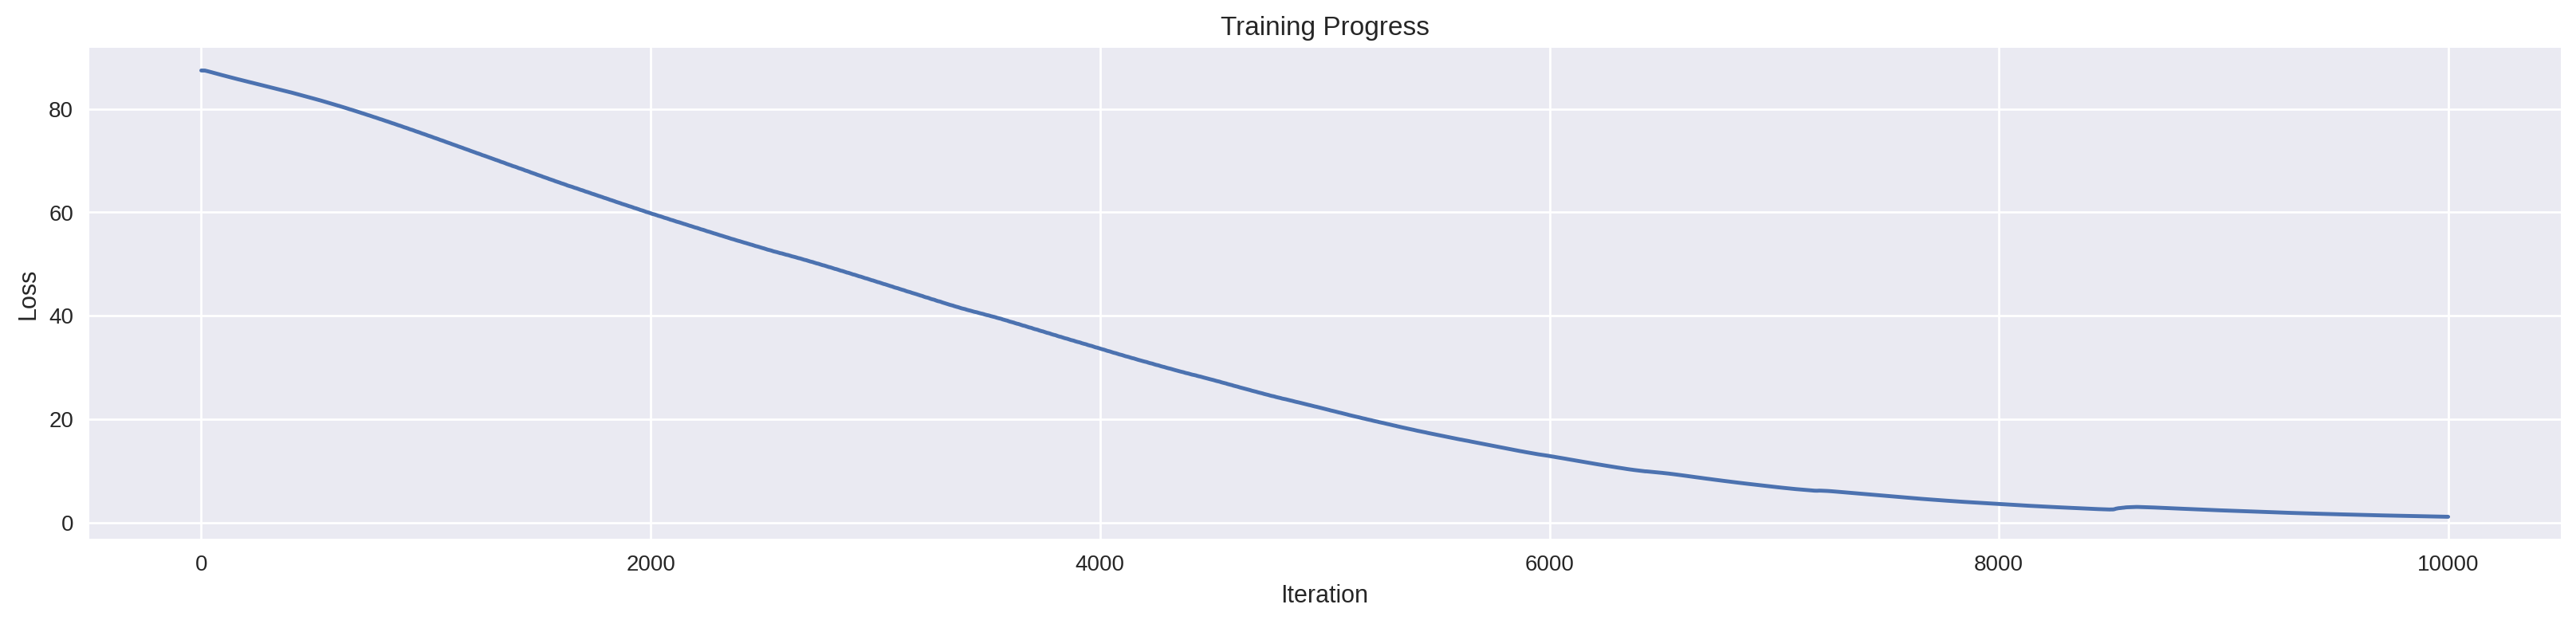

In [17]:
plt.figure(figsize=(20, 4))
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.show()

### __TEST DIFFERENT SEEDS__

In [18]:
seed_chars = ['T', 'A', 'H', 'W', 'I']
for char in seed_chars:
    generated = sample(char, n_chars=150)
    print(char, ':', generated)
    print("-" * 60)

T : Tmlcl upon a timr. TAe was was ining brightly, and the piow tor came up high erbg deak the water the thot, the water began to rise. The crow continued 
------------------------------------------------------------
A : Ance upon a time, on a ver a ver a dim not reshed on ide. There was a little water at the bottom, but his beak could not reacr pickon an to rise. The c
------------------------------------------------------------
H : Hrce upon a ver a time, a thirsty crow was flying is wrarch of water. The sun was shining brightly, and the poor crow was feeling tired and weak.

Afte
------------------------------------------------------------
W : wgcceupon a tile, on a sisearch owas faychiy heak.

At The stirt. the crow thought for a moment. Then he got an idea!

He started pickly ly wnming up k
------------------------------------------------------------
I : iupe wawea hitthe water at the bottom, but his beak could not reach it.

The crow thought for a moment. Then he got an idea!

He

## **SUMMARY**
### **Key Takeaways:**
1. **Cell State = Long-Term Memory**: LSTMs use cell state $\mathbf{c}_t$ for long-term memory, separate from hidden state $\mathbf{h}_t$
2. **Gating Mechanisms**: Three gates (forget, input, output) control information flow and solve vanishing gradients
3. **BPTT with Gradient Highway**: Cell state gradient flows directly through forget gates, enabling learning across 100+ timesteps
5. **Gradient Clipping is Essential**: Clipping to [-5, 5] prevents exploding gradients during BPTT
6. **State Continuity Matters**: Maintaining both $\mathbf{h}_t$ and $\mathbf{c}_t$ across sequences enables long-range learning

### **Possible Extensions:**
1. **Temperature Sampling**: Add `temperature` parameter to control randomness: `p = softmax(logits / T)`
2. **Stacked LSTMs**: Add 2-3 LSTM layers for hierarchical feature learning
3. **Bidirectional LSTM**: Process sequences both forward and backward
4. **Different Datasets**: Shakespeare, Python code, Linux kernel, Wikipedia
5. **Dropout Regularization**: Add dropout between LSTM layers to prevent overfitting
6. **Perplexity Metric**: Calculate `exp(avg_loss)` for better interpretability

### **Comparison: Vanilla RNN vs LSTM:**
| Aspect | Vanilla RNN | LSTM (This Implementation) |
|--------|-------------|----------------------------|
| **Memory** | Hidden state only | Cell state + hidden state |
| **Long-range** | ~20 timesteps | 100-200 timesteps |
| **Gradients** | Vanishing/exploding | Stable via gates |
| **Parameters** | ~15K (same size) | 57K (4x weight matrices) |
| **Training** | Faster (simpler) | Slower (more computation) |
### **References:**
1. Hochreiter, S., & Schmidhuber, J. (1997). *Long Short-Term Memory*. Neural Computation, 9(8), 1735-1780. [**Original LSTM Paper**]
2. Gers, F. A., et al. (2000). *Learning to Forget: Continual Prediction with LSTM*. Neural Computation, 12(10), 2451-2471.
3. Jozefowicz, R., Zaremba, W., & Sutskever, I. (2015). *An Empirical Exploration of Recurrent Network Architectures*. In Proceedings of the 32nd International Conference on Machine Learning (ICML) (pp. 2342–2350). PMLR.

### **Further Reading:**
1. Hochreiter & Schmidhuber (1997). [Long Short-Term Memory](https://www.bioinf.jku.at/publications/older/2604.pdf) — Original LSTM paper
2. Olah, C. (2015). [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) — Visual explanations
3. Cho et al. (2014). Learning Phrase Representations using RNN Encoder-Decoder for SMT — Introduced GRUs
4. Vaswani et al. (2017). Attention Is All You Need. NeurIPS — Transformers replacing LSTMs
5. Goodfellow et al. (2016). Deep Learning. Chapter 10: Sequence Modeling — Comprehensive theory
6. Graves, A. (2013). Generating Sequences With Recurrent Neural Networks — Advanced LSTM techniques